# 3. Evaluation

Welcome to the third notebook of our six part series part of our tutorial on Deep Learning for Human Activity Recognition. This is an optional notebook and will not be covered as part of the live tutorial. Feel free to work through this notebook on your own at home. You can also skip this tutorial if you are already familiar with the evaluation metrics discussed within this notebook. Within the last notebook you learned:

- What data cleaning steps usually need to be performed on a raw sensor dataset?
- What importance does sensor orientation have? How do we match the sensor orientation of different sensors?
- How and why do we perform normalization?
- What is a sliding window? How do we apply it?

This notebook will give you an overview of the state-of-the-art evaluation metrics applied within the field of HAR, but also Machine and Deep Learning in general. Using a common set of evaluation metrics is an important concept in order to judge the predictive performance of methods, but also be able to compare different methods with each other. Using a toy example, you will be introduced to all evaluation metrics encountered within the DL-ARC pipeline. Of course this set of evaluation metrics is not complete and there exist multiple other ones, nevertheless, we identified these evaluation metrics to be the most popular ones. 


After completing this notebook you will be answer the following questions:
- What are common evaluation metrics to evaluate the predicitive performance of a pipeline? How do we compute them?
- What is the confusion matrix? How to read it?


**Note:** Parts of this notebook are inspired by [[1]](#1)

## 3.1. Important Remarks

If you are accessing this tutorial via [Google Colab](https://colab.research.google.com/github/mariusbock/dl-for-har/blob/main/tutorial_notebooks/training.ipynb), first make sure to use Google Colab in English. This will help us to better assist you with issues that might arise during the tutorial. There are two ways to change the default language if it isn't English already:
1. On Google Colab, go to `Help` -> `View in English` 
2. Change the default language of your browser to `English`.

To also ease the communication when communicating errors, enable line numbers within the settings of Colab.

1. On Google Colab, go to `Tools` -> `Settings` -> `Editor` -> `Show line numbers`

In general, we strongly advise you to use Google Colab as it provides you with a working Python distribution as well as free GPU resources. To make Colab use GPUs, you need to change the current notebooks runtime type via:

- `Runtime` -> `Change runtime type` -> `Dropdown` -> `GPU` -> `Save`

**Hint:** you can auto-complete code in Colab via `ctrl` + `spacebar`

For the live tutorial, we require all participants to use Colab. If you decide to rerun the tutorial at later points and rather want to have it run locally on your machine, feel free to clone our [GitHub repository](https://github.com/mariusbock/dl-for-har).

## 3.2. Toy example

For simplicity reasons, we will not work with RWHAR dataset within this notebook, but rather use a toy example. 

Given three subjects which performed a set of 4 activities. Given that we already windowed the data and decided on a label for each window, each subject has a corresponding true label array. We call this the **ground truth** information (see `lines 3-5`).

In [2]:
labels = [0, 1, 2, 3]

gt_sbj1 = [1, 1, 1, 0, 0, 0, 2, 3, 3, 2]
gt_sbj2 = [0, 0, 1, 0, 3, 3, 0, 0, 1, 2]
gt_sbj3 = [3, 3, 3, 0, 0, 1, 1, 2, 2, 2]

Assume that we trained a Deep Learning network on the data of the first subject and evaluated it on the other two subjects. Applying the network now again on the data of each subject will return us three prediction arrays. We call said arrays the **train predicitions** (for subject 1) and **validation predictions** (for subject 2 and 3).

In [3]:
import numpy as np


# these arrays contain the predictions for each subject made by your "network" 
pred_sbj1 = [1, 1, 0, 0, 2, 2, 2, 3, 3, 1]
pred_sbj2 = [0, 1, 1, 1, 3, 2, 1, 1, 0, 2]
pred_sbj3 = [0, 2, 3, 0, 1, 1, 1, 3, 0, 2]

# we use subject 1 to be our training data, i.e. the train ground truth and predictions
train_gt = gt_sbj1
train_pred = pred_sbj1

# we use subject 2 and 3 to be our validation data, i.e. the validation ground truth and predictions
# we therefore concatenate both the data of subject 2 and 3
val_gt = np.concatenate((gt_sbj2, gt_sbj3))
val_pred = np.concatenate((pred_sbj2, pred_sbj3))

We now have everything we need to calculate the evaluation metrics.

## 3.2. Accuracy

Classification accuracy is the ratio of the number of correct preditions out of all predictions that your algorithm made. It is therefore calculated as:

$$\text{accuracy} = \frac{\text{number of true preditions}}{\text{number total preditions}}$$

### Task 1: Implement the accuracy evaluation metric

1. Implement the `accuracy_metric` method which calculates the accuracy as defined above. (`lines 1-9`)
2. Calculate the per-subject, train and validation accuracy using the above defined arrays as input. (`lines 11-24`)



In [14]:
def accuracy_metric(actual, predicted):
    # hints: count the number of correct predicitons
    # write a for loop which iterates over the index of the the actual or predicited array
    # if at a certain index actual==predicted, then increase the correct count
    count_correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            count_correct += 1

    return (count_correct/float(len(actual))* 100)
    

print('\nSubject 1 accuracy:')
print(accuracy_metric(gt_sbj1, pred_sbj1))

print('\nSubject 2 accuracy:')
print(accuracy_metric(gt_sbj2, pred_sbj2))

print('\nSubject 3 accuracy:')
print(accuracy_metric(gt_sbj3, pred_sbj3))

print('\nTraining accuracy:')
print(accuracy_metric(train_gt, train_pred))

print('\nValidation accuracy:')
print(accuracy_metric(val_gt, val_pred))


Subject 1 accuracy:
60.0

Subject 2 accuracy:
40.0

Subject 3 accuracy:
50.0

Training accuracy:
60.0

Validation accuracy:
45.0


## 3.3. True Positives, False Postives, True Negatives and False Negatives

In order to compute the precision, recall and f1-score metrics, we need to first talk about the four types one can classify the outcome of a classification. This is the concept of **true positives, false positives, true negatives and false negatives**. Given a prediction and its ground truth label, the outcome of the prediction for a label i can either be a:

- **True Positive (TP)**: the prediction and ground truth label are both of label i.
- **False Positive (FP)**: the predicition is falsely of prediction i, even though the ground truth label is some other label.
- **True Negative (TN)**: the prediction and ground truth label are both not of label i.
- **False Negative (FN)**: the predicition is not of prediction i, even though the ground truth label is of label i.

For a multiclass problem, this leaves us for each label with a count of TP, FP, TN and FN. In the following we predefined a function for you which, given a label, a prediction and a ground truth array, calculates the numer of TP, FP, TN and FN. We also calculated the TP, FP, TN and FN values for each of the four labels of our toy example.

In [16]:
import pandas as pd

def compute_tp_tn_fn_fp(y_act, y_pred, label):
    y_act = pd.Series(y_act)
    y_pred = pd.Series(y_pred)
    tp = sum((y_act == label) & (y_pred == label))
    tn = sum((y_act != label) & (y_pred != label))
    fn = sum((y_act == label) & (y_pred != label))
    fp = sum((y_act != label) & (y_pred == label))
    return tp, tn, fp, fn

tp_0, tn_0, fp_0, fn_0 = compute_tp_tn_fn_fp(gt_sbj1, pred_sbj1, 0)
tp_1, tn_1, fp_1, fn_1 = compute_tp_tn_fn_fp(gt_sbj1, pred_sbj1, 1)
tp_2, tn_2, fp_2, fn_2 = compute_tp_tn_fn_fp(gt_sbj1, pred_sbj1, 2)
tp_3, tn_3, fp_3, fn_3 = compute_tp_tn_fn_fp(gt_sbj1, pred_sbj1, 3)

print('\nSubject 1 TP, FP, TN and FN:')
print('\nLabel 0:')
print('True Positives: {0}, False Positives: {1}, True Negatives: {2}, False Negatives: {3}'.format(tp_0, tn_0, fp_0, fn_0))
print('\nLabel 1:')
print('True Positives: {0}, False Positives: {1}, True Negatives: {2}, False Negatives: {3}'.format(tp_1, tn_1, fp_1, fn_1))
print('\nLabel 2:')
print('True Positives: {0}, False Positives: {1}, True Negatives: {2}, False Negatives: {3}'.format(tp_2, tn_2, fp_2, fn_2))
print('\nLabel 3:')
print('True Positives: {0}, False Positives: {1}, True Negatives: {2}, False Negatives: {3}'.format(tp_3, tn_3, fp_3, fn_3))


Subject 1 TP, FP, TN and FN:

Label 0:
True Positives: 1, False Positives: 6, True Negatives: 1, False Negatives: 2

Label 1:
True Positives: 2, False Positives: 6, True Negatives: 1, False Negatives: 1

Label 2:
True Positives: 1, False Positives: 6, True Negatives: 2, False Negatives: 1

Label 3:
True Positives: 2, False Positives: 8, True Negatives: 0, False Negatives: 0


## 3.3. Precision, Recall and F1-score

Precision, Recall and F1-score are the most central metrics when it comes classification problems. Each of them assesses a differnt viewpoint of how your algorithm solved the classification problem for a specific label. In the following we will go over how to compute each metric, compute them for each label and take the average across labels to obtain a final assessment for our toy example.

### 3.3.1. Precision

For a class label $i$, precision is the fraction of correct predictions for the label at hand out of all instances where the algorithm predicted the label to be $i$. For a class label $i$ it is computed as:

$$P_i = \frac{\text{TP}_i}{\text{TP}_i + \text{FP}_i} \text{ for given class } i$$

#### Task 2: Implement the precision evaluation metric

1. Implement the `precision_metric` method which calculates the precision for a set of labels as defined above. (`lines 1-16`)
2. Calculate the per-subject, train and validation precision using the above defined arrays as input. (`lines 18-31`)

In [18]:
def precision(actual, predicted, labels):
    # counter variable to accumulate precision across labels
    total_prec = 0
    # iterate of the labels
    for label in labels:
        # calculate the number of tp, fp, tn, fn for said label using the actual and predicted arrays
        tp, tn, fp, fn = compute_tp_tn_fn_fp(actual, predicted, label)
        print('Precision Label {0}:'.format(label))
        # calculate the precision value (hint: multiply by 100 to get nice percentage values)
        prec = tp*100/(tp + fp)
        print(prec)
        # adds up the precision to the total count
        total_prec += prec
    # prints the average precision as the unweigthed average across all classes
    print('Average Precision:')
    print(total_prec / len(labels))
    
print('\nSubject 1 precision:')
precision(gt_sbj1, pred_sbj1, labels)

print('\nSubject 2 precision:')
precision(gt_sbj2, pred_sbj2, labels)

print('\nSubject 3 precision:')
precision(gt_sbj3, pred_sbj3, labels)

print('\nTraining precision:')
precision(train_gt, train_pred, labels)

print('\nValidation precision:')
precision(val_gt, val_pred, labels)


Subject 1 precision:
Precision Label 0:
50.0
Precision Label 1:
66.66666666666667
Precision Label 2:
33.333333333333336
Precision Label 3:
100.0
Average Precision:
62.5

Subject 2 precision:
Precision Label 0:
50.0
Precision Label 1:
20.0
Precision Label 2:
50.0
Precision Label 3:
100.0
Average Precision:
55.0

Subject 3 precision:
Precision Label 0:
33.333333333333336
Precision Label 1:
66.66666666666667
Precision Label 2:
50.0
Precision Label 3:
50.0
Average Precision:
50.0

Training precision:
Precision Label 0:
50.0
Precision Label 1:
66.66666666666667
Precision Label 2:
33.333333333333336
Precision Label 3:
100.0
Average Precision:
62.5

Validation precision:
Precision Label 0:
40.0
Precision Label 1:
37.5
Precision Label 2:
50.0
Precision Label 3:
66.66666666666667
Average Precision:
48.54166666666667


### 3.3.2. Recall

Recall is the fraction of correct predictions for the label at hand over all instances which have the label $i$. For a class label $i$ it is computed as:

$$R_i =\frac{\text{TP}_i}{\text{TP}_i + \text{FN}_i} \text{ for given class } i$$

#### Task 3: Implement the recall evaluation metric

1. Implement the `recall_metric` method which calculates the precision for a set of labels as defined above. (`lines 1-16`)
2. Calculate the per-subject, train and validation precision using the above defined arrays as input. (`lines 18-31`)

In [19]:
def recall(actual, predicted, labels):
    # counter variable to accumulate recall across labels
    total_rec = 0
    # iterate of the labels
    for label in labels:
        # calculate the number of tp, fp, tn, fn for said label using the actual and predicted arrays
        tp, tn, fp, fn = compute_tp_tn_fn_fp(actual, predicted, label)
        print('Recall Label {0}:'.format(label))
        # calculate the recall value (hint: multiply by 100 to get nice percentage values)
        rec = tp * 100 / (tp + fn)
        print(rec)
        # adds up the recall to the total count
        total_rec += rec
    print('Average Recall:')
    # prints the average recall as the unweigthed average across all classes
    print(total_rec / len(labels))
    
print('\nSubject 1 recall:')
recall(gt_sbj1, pred_sbj1, labels)

print('\nSubject 2 recall:')
recall(gt_sbj2, pred_sbj2, labels)

print('\nSubject 3 recall:')
recall(gt_sbj3, pred_sbj3, labels)

print('\nTraining recall:')
recall(train_gt, train_pred, labels)

print('\nValidation recall:')
recall(val_gt, val_pred, labels)


Subject 1 recall:
Recall Label 0:
33.333333333333336
Recall Label 1:
66.66666666666667
Recall Label 2:
50.0
Recall Label 3:
100.0
Average Recall:
62.5

Subject 2 recall:
Recall Label 0:
20.0
Recall Label 1:
50.0
Recall Label 2:
100.0
Recall Label 3:
50.0
Average Recall:
55.0

Subject 3 recall:
Recall Label 0:
50.0
Recall Label 1:
100.0
Recall Label 2:
33.333333333333336
Recall Label 3:
33.333333333333336
Average Recall:
54.16666666666667

Training recall:
Recall Label 0:
33.333333333333336
Recall Label 1:
66.66666666666667
Recall Label 2:
50.0
Recall Label 3:
100.0
Average Recall:
62.5

Validation recall:
Recall Label 0:
28.571428571428573
Recall Label 1:
75.0
Recall Label 2:
50.0
Recall Label 3:
40.0
Average Recall:
48.39285714285714


### 3.3.3. F1-score

The F1-score combines both recall and precision into one measure. It is computed as the harmonic mean of precision and recall, i.e.:

$$F_i = 2 * \frac{P_i * R_i}{P_i + R_i}$$

#### Task 3: Implement the F1-score evaluation metric

1. Implement the `f1_score_metric` method which calculates the precision for a set of labels as defined above. (`lines 1-16`)
2. Calculate the per-subject, train and validation precision using the above defined arrays as input. (`lines 18-31`)

In [22]:
def f1_score_metric(actual, predicted, labels):
    # counter variable to accumulate f1-score across labels
    total_f1 = 0
    # iterate of the labels
    for label in labels:
        # calculate the number of tp, fp, tn, fn for said label using the actual and predicted arrays
        tp, tn, fp, fn = compute_tp_tn_fn_fp(actual, predicted, label)
        print('F1-score Label {0}:'.format(label))
        # calculate the recall and precision value
        rec = tp / (tp + fn)
        prec = tp / (tp + fp)
        # define the counter and denominator of the f1-score formula above
        counter = 2 * prec * rec
        denominator = prec + rec
        # caluclate the f1 score for the given label
        f1 = counter/denominator * 100
        print(f1)
        # adds up the f1-score to the total count
        total_f1 += f1
    print('Average F1-score:')
    # prints the average f1-score as the unweigthed average across all classes
    print(total_f1 / len(labels))
    
print('\nSubject 1 F1-score:')
f1_score_metric(gt_sbj1, pred_sbj1, labels)

print('\nSubject 2 F1-score:')
f1_score_metric(gt_sbj2, pred_sbj2, labels)

print('\nSubject 3 F1-score:')
f1_score_metric(gt_sbj3, pred_sbj3, labels)

print('\nTraining F1-score:')
f1_score_metric(train_gt, train_pred, labels)

print('\nValidation F1-score:')
f1_score_metric(val_gt, val_pred, labels)


Subject 1 F1-score:
F1-score Label 0:
40.0
F1-score Label 1:
66.66666666666666
F1-score Label 2:
40.0
F1-score Label 3:
100.0
Average F1-score:
61.666666666666664

Subject 2 F1-score:
F1-score Label 0:
28.571428571428577
F1-score Label 1:
28.571428571428577
F1-score Label 2:
66.66666666666666
F1-score Label 3:
66.66666666666666
Average F1-score:
47.61904761904762

Subject 3 F1-score:
F1-score Label 0:
40.0
F1-score Label 1:
80.0
F1-score Label 2:
40.0
F1-score Label 3:
40.0
Average F1-score:
50.0

Training F1-score:
F1-score Label 0:
40.0
F1-score Label 1:
66.66666666666666
F1-score Label 2:
40.0
F1-score Label 3:
100.0
Average F1-score:
61.666666666666664

Validation F1-score:
F1-score Label 0:
33.33333333333333
F1-score Label 1:
50.0
F1-score Label 2:
50.0
F1-score Label 3:
50.0
Average F1-score:
45.83333333333333


## 3.3. Confusion matrix

A confusion matrix gives you a tabular overview of all predicitions compared to the ground truth values. The counts of actual labels are oriented horizontally, i.e. column-wise. The counts of predicted labels are oriented vertically, i.e. row-wise. A perfect confusion matrix would be a diagonal matrix, i.e. all labels are correctly predicted and have the same predicted label and ground truth label.

You can use a confusion matrix to quickly spot which classes your algorithm might have struggled with the most.

### Task 5: Interpreting the confusion matrix

1. Run the code below. How can you interpret the results? Do you spot any activities/ subjects which your algorithm paticularly struggeled with? Which activities/ subjects did you algorithm perfom well on? 

\Confusion Matrix Subject 1:
\Confusion Matrix Subject 2:
\Confusion Matrix Subject 3:
\Confusion Matrix Training:
\Confusion Matrix Validation:


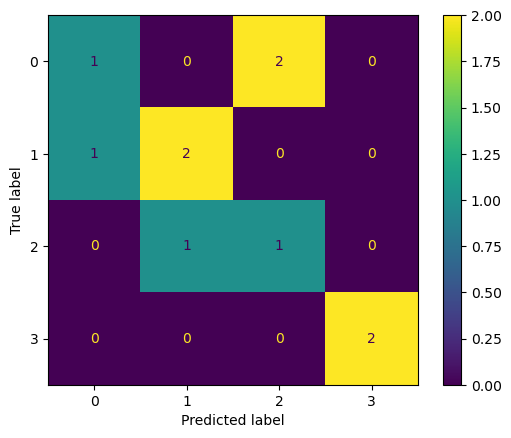

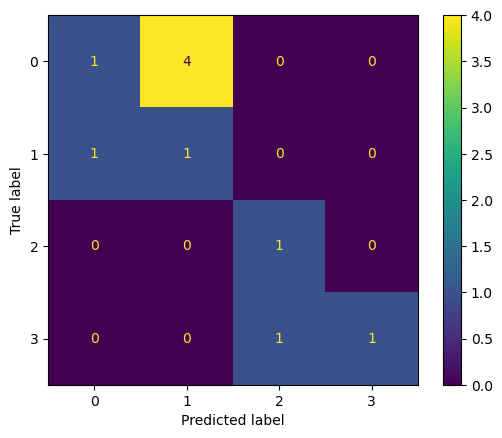

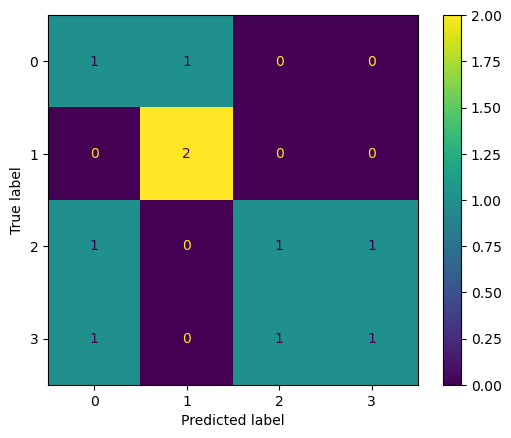

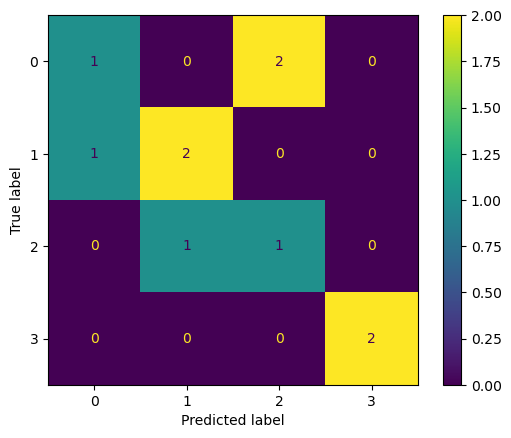

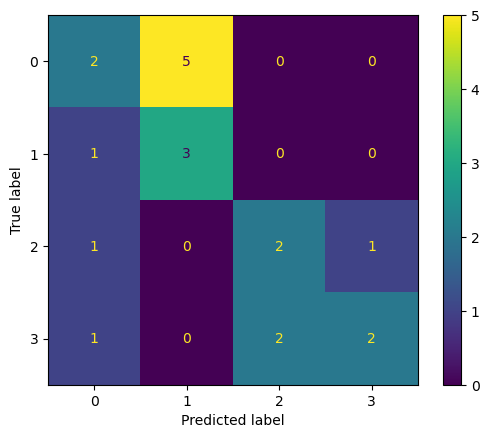

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time 


def plot_confusion_matrix(actual, predicted, labels):
    cm = confusion_matrix(actual, predicted, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot() 

print('\Confusion Matrix Subject 1:')
plot_confusion_matrix(gt_sbj1, pred_sbj1, labels)

print('\Confusion Matrix Subject 2:')
plot_confusion_matrix(gt_sbj2, pred_sbj2, labels)

print('\Confusion Matrix Subject 3:')
plot_confusion_matrix(gt_sbj3, pred_sbj3, labels)

print('\Confusion Matrix Training:')
plot_confusion_matrix(train_gt, train_pred, labels)

print('\Confusion Matrix Validation:')
plot_confusion_matrix(val_gt, val_pred, labels)

# References

<a id="1">[1]</a>   Jason Brownlee. 2016. How To Implement Machine Learning Metrics From Scratch in Python. In Code Algorithms From Scratch. https://machinelearningmastery.com/implement-machine-learning-algorithm-performance-metrics-scratch-python/

